In [543]:
import os
import warnings

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap
from collections import defaultdict

In [544]:
# Set TensorFlow logging level to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
# Suppress TF-DF warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_decision_forests")


In [400]:
cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492

In [401]:
cali_df = pd.read_csv(cali_housing_path)

In [402]:
print(cali_df.head())

   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.5170

In [403]:
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [405]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [406]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [407]:
subset_indices = np.random.choice(X_train.index, size=len(X_train), replace=False)

X_train_subset = X_train.loc[subset_indices]
y_train_subset = y_train.loc[subset_indices]

print(X_train_scaled.head())

   Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  Households  \
0      -0.220234    0.183029  -0.505330     -0.583271   -0.625333   -0.554684   
1       1.131720   -0.453352  -0.451797     -0.319166   -0.779725   -0.428479   
2       0.635054   -0.930638   0.592095      0.475528    1.118858    0.649526   
3       0.737734   -1.248828  -0.828835     -0.968722   -0.899710   -0.977998   
4      -0.158268   -1.169280  -0.095988     -0.114544   -0.374776   -0.381152   

   Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
0  1.311518  -1.639785          -0.391522        1.490960   
1  1.054222  -1.455058          -0.700199        1.220967   
2  0.764180  -1.110565          -0.144717        0.850569   
3  0.591090  -1.050653          -0.568215        0.701779   
4  1.723191  -0.296764           2.921674        1.372870   

   Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
0              1.449301            -0.918829                 -1.210694  


In [408]:
X_train_subset = X_train_subset.reset_index(drop=True)
y_train_subset = y_train_subset.reset_index(drop=True)

In [409]:
X_train_tensor = tf.constant(X_train_subset.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train_subset.values, dtype=tf.float32)
print(y_train_tensor.shape)

(16512, 1)


In [567]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method = "RANDOM",verbose = 1): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.verbose = verbose
        self.estimators = []
        self.lime_explainers = []
        self.shap_explainers = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed, # try to set this first. Maybe this is enough
            verbose=1
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(X.index, size=subset_size, replace=False)
            X_train = X.loc[subset_indices].reset_index(drop=True)
            y_train = y.loc[subset_indices].reset_index(drop=True)
            
            X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor,verbose=0)
            self.estimators.append(estimator)
            
        # initiate explainers
        for model in self.estimators:
            lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns.tolist(), mode='regression')
            self.lime_explainers.append(lime_explainer)
            masker = shap.maskers.Independent(data = X_train.values)
            shap_explainer = shap.Explainer(model, masker=masker, feature_names=X.columns.tolist())
            self.shap_explainers.append(shap_explainer)
    
    #something's not right here
    def predict_mean(self, X):
        predictions = []
        
        for estimator in self.estimators:
            estimator_predictions = estimator.predict(X,verbose=0)  # Get predictions from the current estimator
            predictions.append(estimator_predictions)
        
        # Stack all predictions along the last axis (-1)
        predictions_stacked = tf.stack(predictions, axis=-1)
        
        # Compute mean and variance across the stacked predictions
        mean_prediction = tf.reduce_mean(predictions_stacked, axis=-1)
        sd_prediction = tf.math.reduce_std(predictions_stacked, axis=-1)
        
        return mean_prediction, sd_prediction
    
    def explain_lime(self, X):
        lime_explanations = []
        
        for estimator, explainer in zip(self.estimators, self.lime_explainers):
            for i in range(len(X)): 
                instance_explanation = explainer.explain_instance(X.iloc[i], estimator.predict, num_features=X.shape[1])
                lime_explanations.append(instance_explanation)
        return lime_explanations
    
    def explain_shap(self, X):
        shap_values = []
        
        for estimator, explainer in zip(self.estimators, self.shap_explainers):
            shap_value = explainer(X)
            shap_values.append(shap_value)
        
        return shap_values
    

In [568]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM',
    verbose=0
)

In [569]:
gbt_model_50 = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8,
    sample_method='RANDOM',
    verbose=0
)

In [570]:
gbt_model.fit(X_train_scaled, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphp2xxk9d as temporary training directory


[WARNING 24-06-03 18:25:21.7021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:21.7022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:21.7022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhcdby13 as temporary training directory


[INFO 24-06-03 18:25:22.9451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphp2xxk9d/model/ with prefix b5698b540ab74a82
[INFO 24-06-03 18:25:22.9464 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:25:22.9464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:23.0371 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:23.0371 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:23.0372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkaxl8onl as temporary training directory


[INFO 24-06-03 18:25:23.5136 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhcdby13/model/ with prefix 3c663d6487094a2d
[INFO 24-06-03 18:25:23.5142 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:23.6243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:23.6244 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:23.6244 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphuetsu2n as temporary training directory


[INFO 24-06-03 18:25:24.5017 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkaxl8onl/model/ with prefix bcc981c0d8ba4053
[INFO 24-06-03 18:25:24.5034 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:24.5922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:24.5922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:24.5922 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw00avxme as temporary training directory


[INFO 24-06-03 18:25:25.3208 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphuetsu2n/model/ with prefix fa5e0b0938644884
[INFO 24-06-03 18:25:25.3221 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:25.4035 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:25.4035 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:25.4036 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kl97vdm as temporary training directory


[INFO 24-06-03 18:25:25.9418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw00avxme/model/ with prefix bb5c52c4467a4e68
[INFO 24-06-03 18:25:25.9425 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:26.0412 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:26.0412 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:26.0412 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3g5s5ek as temporary training directory


[INFO 24-06-03 18:25:26.6301 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kl97vdm/model/ with prefix a530ad0598504dd8
[INFO 24-06-03 18:25:26.6310 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:26.7075 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:26.7075 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:26.7075 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuunldgf6 as temporary training directory


[INFO 24-06-03 18:25:27.5409 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3g5s5ek/model/ with prefix fb52f5b797674b89
[INFO 24-06-03 18:25:27.5423 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:27.6181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:27.6181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:27.6181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_6kzl_9 as temporary training directory


[INFO 24-06-03 18:25:28.4614 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuunldgf6/model/ with prefix 43a0d8f8677d45bb
[INFO 24-06-03 18:25:28.4630 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:28.5438 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:28.5438 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:28.5438 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms_rbbjw as temporary training directory


[INFO 24-06-03 18:25:29.3153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_6kzl_9/model/ with prefix ba383b936eee4b25
[INFO 24-06-03 18:25:29.3167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:29.3906 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:29.3906 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:29.3906 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyuj9nfmt as temporary training directory


[INFO 24-06-03 18:25:30.1561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms_rbbjw/model/ with prefix e44367b8264d46c9
[INFO 24-06-03 18:25:30.1576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:30.2370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:30.2370 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:30.2370 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sarps_t as temporary training directory


[INFO 24-06-03 18:25:30.8793 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyuj9nfmt/model/ with prefix ed50af533b8f44d2
[INFO 24-06-03 18:25:30.8804 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:30.9570 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:30.9570 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:30.9570 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqun0_8pe as temporary training directory


[INFO 24-06-03 18:25:31.4402 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sarps_t/model/ with prefix 6b7a84a018ac4b2e
[INFO 24-06-03 18:25:31.4409 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:31.5141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:31.5141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:31.5141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxp_cx1fm as temporary training directory


[INFO 24-06-03 18:25:32.1777 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqun0_8pe/model/ with prefix 2edb493b598d4d34
[INFO 24-06-03 18:25:32.1789 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:32.2468 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:32.2468 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:32.2468 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa44_ms12 as temporary training directory


[INFO 24-06-03 18:25:32.9388 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxp_cx1fm/model/ with prefix 1bca596504a84717
[INFO 24-06-03 18:25:32.9401 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:33.0141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:33.0142 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:33.0142 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs4xsjln as temporary training directory


[INFO 24-06-03 18:25:33.4494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa44_ms12/model/ with prefix 94538f0d59c04c4e
[INFO 24-06-03 18:25:33.4499 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:25:33.4499 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:33.5257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:33.5258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:33.5258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyyu_cxg0 as temporary training directory


[INFO 24-06-03 18:25:33.9945 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs4xsjln/model/ with prefix 0182f942487141bd
[INFO 24-06-03 18:25:33.9951 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:34.0702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:34.0702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:34.0702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz14t60nt as temporary training directory


[INFO 24-06-03 18:25:34.8965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyyu_cxg0/model/ with prefix d1d3dc0646df4e10
[INFO 24-06-03 18:25:34.8981 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:34.9672 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:34.9672 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:34.9672 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36nmxhco as temporary training directory


[INFO 24-06-03 18:25:35.5388 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz14t60nt/model/ with prefix be83128444404e92
[INFO 24-06-03 18:25:35.5397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:35.6188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:35.6188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:35.6188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtjlfge5 as temporary training directory


[INFO 24-06-03 18:25:36.1854 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36nmxhco/model/ with prefix afddd7b558eb4cee
[INFO 24-06-03 18:25:36.1863 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:36.2532 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:36.2533 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:36.2533 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphep_zwku as temporary training directory


[INFO 24-06-03 18:25:36.7341 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtjlfge5/model/ with prefix b367e12da0604cb0
[INFO 24-06-03 18:25:36.7347 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:36.8034 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:36.8035 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:36.8035 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xuy76f8 as temporary training directory


[INFO 24-06-03 18:25:37.4993 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphep_zwku/model/ with prefix 9ddd1857e5994cd9
[INFO 24-06-03 18:25:37.5005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:37.5687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:37.5687 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:37.5688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfygy13gw as temporary training directory


[INFO 24-06-03 18:25:38.3720 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xuy76f8/model/ with prefix a37dc5558e9e49a7
[INFO 24-06-03 18:25:38.3735 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:38.4440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:38.4440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:38.4440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjuj_i41b as temporary training directory


[INFO 24-06-03 18:25:39.1241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfygy13gw/model/ with prefix 8a834620702b4c0e
[INFO 24-06-03 18:25:39.1252 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:39.1949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:39.1949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:39.1949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ozq8mx3 as temporary training directory


[INFO 24-06-03 18:25:39.8358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjuj_i41b/model/ with prefix 446e63954fea4bdc
[INFO 24-06-03 18:25:39.8368 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:39.9054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:39.9054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:39.9055 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nlmx_9r as temporary training directory


[INFO 24-06-03 18:25:40.4145 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ozq8mx3/model/ with prefix 9f6cf9e348f34cb8
[INFO 24-06-03 18:25:40.4151 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:40.4845 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:40.4846 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:40.4846 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqi782fzv as temporary training directory


[INFO 24-06-03 18:25:41.2378 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nlmx_9r/model/ with prefix 348bd2f4846b433b
[INFO 24-06-03 18:25:41.2392 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:41.3106 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:41.3107 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:41.3107 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjany1q0q as temporary training directory


[INFO 24-06-03 18:25:42.1471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqi782fzv/model/ with prefix 40d061c08f1c4e0a
[INFO 24-06-03 18:25:42.1487 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:42.2157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:42.2157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:42.2157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppab9l878 as temporary training directory


[INFO 24-06-03 18:25:42.7664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjany1q0q/model/ with prefix d311552ebe4d4892
[INFO 24-06-03 18:25:42.7672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:42.8338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:42.8338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:42.8338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sf2q9od as temporary training directory


[INFO 24-06-03 18:25:43.4907 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppab9l878/model/ with prefix cd7925bf14c846bc
[INFO 24-06-03 18:25:43.4918 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:25:43.4918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:43.5585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:43.5585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:43.5585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkl8u1lbk as temporary training directory


[INFO 24-06-03 18:25:44.3372 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sf2q9od/model/ with prefix 04b1e95a5dae42b3
[INFO 24-06-03 18:25:44.3386 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:44.4088 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:44.4088 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:44.4088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_qgxsi4 as temporary training directory


[INFO 24-06-03 18:25:45.0915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkl8u1lbk/model/ with prefix 2f2fa0a85ce148a8
[INFO 24-06-03 18:25:45.0927 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:45.1659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:45.1660 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:45.1660 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2vd8xlqh as temporary training directory


[INFO 24-06-03 18:25:45.6598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_qgxsi4/model/ with prefix f0a0a3089a5a4e85
[INFO 24-06-03 18:25:45.6605 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:45.7284 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:45.7285 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:45.7285 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwu74y5_i as temporary training directory


[INFO 24-06-03 18:25:46.3273 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2vd8xlqh/model/ with prefix 66c39095ff6943e9
[INFO 24-06-03 18:25:46.3283 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:46.3982 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:46.3983 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:46.3983 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfoaddw7v as temporary training directory


[INFO 24-06-03 18:25:47.1716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwu74y5_i/model/ with prefix f81275c010c442aa
[INFO 24-06-03 18:25:47.1731 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:47.2427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:47.2428 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:47.2428 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0r1qqfn6 as temporary training directory


[INFO 24-06-03 18:25:47.7430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfoaddw7v/model/ with prefix 730810ad373b41ea
[INFO 24-06-03 18:25:47.7437 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:47.8105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:47.8106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:47.8106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62l9brl7 as temporary training directory


[INFO 24-06-03 18:25:48.4758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0r1qqfn6/model/ with prefix 13979d0febef411e
[INFO 24-06-03 18:25:48.4770 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:48.5466 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:48.5466 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:48.5466 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqgeg45d5 as temporary training directory


[INFO 24-06-03 18:25:49.0237 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62l9brl7/model/ with prefix 4853b823e921416b
[INFO 24-06-03 18:25:49.0243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:49.1000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:49.1000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:49.1000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzehasens as temporary training directory


[INFO 24-06-03 18:25:49.6218 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqgeg45d5/model/ with prefix e2dc2b9038a04d33
[INFO 24-06-03 18:25:49.6226 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:49.6922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:49.6922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:49.6923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdat9ypqn as temporary training directory


[INFO 24-06-03 18:25:50.2191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzehasens/model/ with prefix 2639df7f61524deb
[INFO 24-06-03 18:25:50.2198 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:50.2881 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:50.2881 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:50.2881 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0uh3d9s as temporary training directory


[INFO 24-06-03 18:25:50.9633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdat9ypqn/model/ with prefix f9d464fe9383493f
[INFO 24-06-03 18:25:50.9645 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:51.0313 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:51.0314 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:51.0314 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpignjkzdg as temporary training directory


[INFO 24-06-03 18:25:51.8746 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0uh3d9s/model/ with prefix dacac8aa542e423a
[INFO 24-06-03 18:25:51.8762 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:51.9434 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:51.9434 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:51.9434 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27bxvve6 as temporary training directory


[INFO 24-06-03 18:25:52.4810 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpignjkzdg/model/ with prefix 597b64d1233e4bc2
[INFO 24-06-03 18:25:52.4818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:52.5535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:52.5535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:52.5535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xzwylq8 as temporary training directory


[INFO 24-06-03 18:25:53.1689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27bxvve6/model/ with prefix 447cc1f7e98a4bd2
[INFO 24-06-03 18:25:53.1697 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:53.2419 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:53.2420 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:53.2420 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpac5gyyv7 as temporary training directory


[INFO 24-06-03 18:25:54.0622 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xzwylq8/model/ with prefix 0fcd040e2a034ba2
[INFO 24-06-03 18:25:54.0638 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:25:54.0638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:54.1322 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:54.1322 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:54.1323 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1y0ya_f as temporary training directory


[INFO 24-06-03 18:25:54.6400 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpac5gyyv7/model/ with prefix 0d4bba532faa4182
[INFO 24-06-03 18:25:54.6407 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:54.7072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:54.7072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:54.7072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtik8uqw as temporary training directory


[INFO 24-06-03 18:25:55.2240 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1y0ya_f/model/ with prefix c59df34bdc974942
[INFO 24-06-03 18:25:55.2247 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:55.2907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:55.2908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:55.2908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_6syas7 as temporary training directory


[INFO 24-06-03 18:25:55.9026 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtik8uqw/model/ with prefix 0a634ad6e7cb4293
[INFO 24-06-03 18:25:55.9036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:55.9705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:55.9705 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:55.9705 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5m1vkhz as temporary training directory


[INFO 24-06-03 18:25:56.6332 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_6syas7/model/ with prefix eba60d69418944f3
[INFO 24-06-03 18:25:56.6343 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:56.7046 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:56.7046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:56.7046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5nqvxhew as temporary training directory


[INFO 24-06-03 18:25:57.1619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5m1vkhz/model/ with prefix f6dac35c7edd4fa6
[INFO 24-06-03 18:25:57.1624 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:57.2297 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:57.2297 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:57.2297 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpki8gk5mg as temporary training directory


[INFO 24-06-03 18:25:57.8621 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5nqvxhew/model/ with prefix 4d3216cd00b940d5
[INFO 24-06-03 18:25:57.8632 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:57.9314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:57.9314 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:57.9314 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuk45sld as temporary training directory


[INFO 24-06-03 18:25:58.6825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpki8gk5mg/model/ with prefix 0ff1dbf836794549
[INFO 24-06-03 18:25:58.6838 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:58.7516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:58.7516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:58.7516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3kpysiw as temporary training directory


[INFO 24-06-03 18:25:59.2995 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuk45sld/model/ with prefix 75bd6f5c77264488
[INFO 24-06-03 18:25:59.3003 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:25:59.3678 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:59.3678 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:25:59.3678 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1n1f2djq as temporary training directory


[INFO 24-06-03 18:26:00.2375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3kpysiw/model/ with prefix 97234b9cba924dd4
[INFO 24-06-03 18:26:00.2391 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:00.3091 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:00.3091 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:00.3091 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpulf_zwnq as temporary training directory


[INFO 24-06-03 18:26:00.9002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1n1f2djq/model/ with prefix 8ccd8a3c14ad40b1
[INFO 24-06-03 18:26:00.9011 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:00.9687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:00.9688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:00.9688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8lw0_zfi as temporary training directory


[INFO 24-06-03 18:26:01.4589 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpulf_zwnq/model/ with prefix 1c96961e87784dbc
[INFO 24-06-03 18:26:01.4595 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:01.5262 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:01.5262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:01.5262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeyaksnyt as temporary training directory


[INFO 24-06-03 18:26:02.0808 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8lw0_zfi/model/ with prefix afb85b9b743645ab
[INFO 24-06-03 18:26:02.0816 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:02.1585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:02.1585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:02.1585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxeih95vg as temporary training directory


[INFO 24-06-03 18:26:02.8232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeyaksnyt/model/ with prefix 13be4b0ff55e49bc
[INFO 24-06-03 18:26:02.8243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:02.8917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:02.8917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:02.8917 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg16ii87v as temporary training directory


[INFO 24-06-03 18:26:03.5317 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxeih95vg/model/ with prefix 2296227b76734e2d
[INFO 24-06-03 18:26:03.5327 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:03.6029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:03.6029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:03.6029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9z671u3 as temporary training directory


[INFO 24-06-03 18:26:04.2916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg16ii87v/model/ with prefix e2d603e5bf764abd
[INFO 24-06-03 18:26:04.2928 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:26:04.2928 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:04.3621 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:04.3621 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:04.3621 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpewetg3pg as temporary training directory


[INFO 24-06-03 18:26:04.8339 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9z671u3/model/ with prefix 7d65f666f6934760
[INFO 24-06-03 18:26:04.8344 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:04.9042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:04.9042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:04.9042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhnby60s as temporary training directory


[INFO 24-06-03 18:26:05.7058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpewetg3pg/model/ with prefix e846ee39a83b40e6
[INFO 24-06-03 18:26:05.7073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:05.7761 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:05.7762 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:05.7762 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg009aagh as temporary training directory


[INFO 24-06-03 18:26:06.4533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhnby60s/model/ with prefix 505ade53e43b4830
[INFO 24-06-03 18:26:06.4544 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:06.5244 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:06.5244 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:06.5244 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdplgo5v as temporary training directory


[INFO 24-06-03 18:26:07.0099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg009aagh/model/ with prefix c7d4dbcd2263497d
[INFO 24-06-03 18:26:07.0105 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:07.0816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:07.0816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:07.0816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquijws1q as temporary training directory


[INFO 24-06-03 18:26:07.6965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdplgo5v/model/ with prefix e515d9c4c6fd42fa
[INFO 24-06-03 18:26:07.6975 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:07.7645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:07.7645 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:07.7645 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp652xo0q8 as temporary training directory


[INFO 24-06-03 18:26:08.2486 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquijws1q/model/ with prefix 523d3aad59d14f37
[INFO 24-06-03 18:26:08.2492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:08.3187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:08.3187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:08.3187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl53dzl_u as temporary training directory


[INFO 24-06-03 18:26:08.8309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp652xo0q8/model/ with prefix c9abff22fa084524
[INFO 24-06-03 18:26:08.8315 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:08.8986 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:08.8986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:08.8986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy9hni25 as temporary training directory


[INFO 24-06-03 18:26:09.4309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl53dzl_u/model/ with prefix 4b5f4e306cce4736
[INFO 24-06-03 18:26:09.4316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:09.5032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:09.5032 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:09.5032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxgp18tl as temporary training directory


[INFO 24-06-03 18:26:09.9543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy9hni25/model/ with prefix 23233412a4a44c33
[INFO 24-06-03 18:26:09.9548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:10.0229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:10.0230 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:10.0230 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp202dkb_q as temporary training directory


[INFO 24-06-03 18:26:10.8704 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxgp18tl/model/ with prefix 7bba66e7467b4fe3
[INFO 24-06-03 18:26:10.8720 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:10.9385 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:10.9385 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:10.9385 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43nvm9kw as temporary training directory


[INFO 24-06-03 18:26:11.9629 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp202dkb_q/model/ with prefix a37bcce603274977
[INFO 24-06-03 18:26:11.9656 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:12.0615 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:12.0616 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:12.0616 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp512kxsms as temporary training directory


[INFO 24-06-03 18:26:12.6678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43nvm9kw/model/ with prefix 272d4eaa11494715
[INFO 24-06-03 18:26:12.6689 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:12.7396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:12.7396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:12.7396 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpno3tkat1 as temporary training directory


[INFO 24-06-03 18:26:13.3269 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp512kxsms/model/ with prefix d742699fdd534ae7
[INFO 24-06-03 18:26:13.3277 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:13.3998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:13.3998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:13.3998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43e9z47u as temporary training directory


[INFO 24-06-03 18:26:13.8821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpno3tkat1/model/ with prefix 27e3e8f1274648a7
[INFO 24-06-03 18:26:13.8827 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:13.9603 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:13.9603 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:13.9603 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp114rvn9x as temporary training directory


[INFO 24-06-03 18:26:14.4394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43e9z47u/model/ with prefix f7ebc0a97ccb43f1
[INFO 24-06-03 18:26:14.4400 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:26:14.4400 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:14.5132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:14.5133 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:14.5133 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgnoqppuv as temporary training directory


[INFO 24-06-03 18:26:15.3772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp114rvn9x/model/ with prefix a3dfbe20f5194a3e
[INFO 24-06-03 18:26:15.3787 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:15.4501 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:15.4501 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:15.4501 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77gw8ma5 as temporary training directory


[INFO 24-06-03 18:26:15.9546 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgnoqppuv/model/ with prefix 17d1d82330c44274
[INFO 24-06-03 18:26:15.9553 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:16.0266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:16.0266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:16.0266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ucaavaz as temporary training directory


[INFO 24-06-03 18:26:16.5095 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77gw8ma5/model/ with prefix 4d97bb2ea7384cc6
[INFO 24-06-03 18:26:16.5101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:16.5798 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:16.5799 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:16.5799 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwkdbzvdw as temporary training directory


[INFO 24-06-03 18:26:17.4231 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ucaavaz/model/ with prefix 58d1a3b2d0e148fe
[INFO 24-06-03 18:26:17.4247 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:17.4998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:17.4998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:17.4998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvictrmwx as temporary training directory


[INFO 24-06-03 18:26:18.1253 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwkdbzvdw/model/ with prefix d78cf6dbe3204fc1
[INFO 24-06-03 18:26:18.1263 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:26:18.1988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:18.1989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:26:18.1989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-03 18:26:19.0096 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvictrmwx/model/ with prefix 4e32f076a7fc45b9
[INFO 24-06-03 18:26:19.0111 CEST kernel.cc:1061] Use fast generic engine


In [571]:
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.5, random_state=RANDOM_SEED)
gbt_model_50.fit(X_train_subset, y_train_subset)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc4eg_q0 as temporary training directory


[WARNING 24-06-03 18:29:16.4896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:16.4898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:16.4898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_ldmxr_ as temporary training directory


[INFO 24-06-03 18:29:17.2785 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc4eg_q0/model/ with prefix 5629608d0a92469e
[INFO 24-06-03 18:29:17.2793 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:29:17.2794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:17.3593 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:17.3593 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:17.3593 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu59k1q4x as temporary training directory


[INFO 24-06-03 18:29:17.8874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_ldmxr_/model/ with prefix bd6989a22777486b
[INFO 24-06-03 18:29:17.8881 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:17.9784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:17.9784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:17.9784 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl2kr0pwh as temporary training directory


[INFO 24-06-03 18:29:18.7318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu59k1q4x/model/ with prefix 6f9b67ededb846fb
[INFO 24-06-03 18:29:18.7334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:18.8049 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:18.8050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:18.8050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuwp_zrpd as temporary training directory


[INFO 24-06-03 18:29:19.3128 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl2kr0pwh/model/ with prefix acc3fca0a90e42be
[INFO 24-06-03 18:29:19.3136 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:19.3852 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:19.3852 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:19.3852 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5i6awe4 as temporary training directory


[INFO 24-06-03 18:29:19.8522 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuwp_zrpd/model/ with prefix d24f106ed0664283
[INFO 24-06-03 18:29:19.8528 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:19.9278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:19.9278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:19.9278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5otmhmh0 as temporary training directory


[INFO 24-06-03 18:29:20.4819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5i6awe4/model/ with prefix bd6453d1a3864dd0
[INFO 24-06-03 18:29:20.4829 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:20.5589 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:20.5589 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:20.5589 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm4uhfg9f as temporary training directory


[INFO 24-06-03 18:29:21.0678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5otmhmh0/model/ with prefix 489982da585a4070
[INFO 24-06-03 18:29:21.0686 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:21.1353 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:21.1353 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:21.1353 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe05t4fta as temporary training directory


[INFO 24-06-03 18:29:21.5759 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm4uhfg9f/model/ with prefix 64b24f59ef83405f
[INFO 24-06-03 18:29:21.5765 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:21.6462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:21.6463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:21.6463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavcxikaz as temporary training directory


[INFO 24-06-03 18:29:22.3913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe05t4fta/model/ with prefix bb8e643b296248d6
[INFO 24-06-03 18:29:22.3929 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:22.4634 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:22.4634 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:22.4635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd28m8c7s as temporary training directory


[INFO 24-06-03 18:29:22.8786 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavcxikaz/model/ with prefix 8c854a538c7a40bd
[INFO 24-06-03 18:29:22.8791 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:22.9596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:22.9596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:22.9596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7vn2slv as temporary training directory


[INFO 24-06-03 18:29:23.6348 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd28m8c7s/model/ with prefix 9c40bb845ff94b10
[INFO 24-06-03 18:29:23.6362 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:23.7021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:23.7022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:23.7022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4uk4yzwd as temporary training directory


[INFO 24-06-03 18:29:24.4358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7vn2slv/model/ with prefix 5751944f49274582
[INFO 24-06-03 18:29:24.4374 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:24.5059 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:24.5059 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:24.5059 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0o1jez8 as temporary training directory


[INFO 24-06-03 18:29:24.9654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4uk4yzwd/model/ with prefix 26351d2e5d6b40f9
[INFO 24-06-03 18:29:24.9661 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:25.0383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:25.0383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:25.0383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh4tnidp as temporary training directory


[INFO 24-06-03 18:29:25.7109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0o1jez8/model/ with prefix e1e76cd66a8e4c0e
[INFO 24-06-03 18:29:25.7123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:25.7803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:25.7803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:25.7803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5oflyn3 as temporary training directory


[INFO 24-06-03 18:29:26.4376 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh4tnidp/model/ with prefix 1c4e3b3f89634b86
[INFO 24-06-03 18:29:26.4390 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:26.5161 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:26.5161 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:26.5161 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltb3_uo7 as temporary training directory


[INFO 24-06-03 18:29:27.1517 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5oflyn3/model/ with prefix 542ba4e6a8884df2
[INFO 24-06-03 18:29:27.1530 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:27.2181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:27.2181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:27.2181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpornt2sxe as temporary training directory


[INFO 24-06-03 18:29:27.8779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltb3_uo7/model/ with prefix 9777f33416dd4c9d
[INFO 24-06-03 18:29:27.8792 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:29:27.8792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:27.9468 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:27.9468 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:27.9469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsg0bwoat as temporary training directory


[INFO 24-06-03 18:29:28.6168 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpornt2sxe/model/ with prefix 979e43a6591d4aef
[INFO 24-06-03 18:29:28.6181 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:28.6933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:28.6933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:28.6933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz58ett0c as temporary training directory


[INFO 24-06-03 18:29:29.4120 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsg0bwoat/model/ with prefix 9f6d920812a8459d
[INFO 24-06-03 18:29:29.4134 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:29.4815 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:29.4815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:29.4815 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9b6brkea as temporary training directory


[INFO 24-06-03 18:29:30.2086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz58ett0c/model/ with prefix 98864dbfa7b84144
[INFO 24-06-03 18:29:30.2100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:30.2748 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:30.2748 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:30.2748 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ua6dgqi as temporary training directory


[INFO 24-06-03 18:29:31.0165 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9b6brkea/model/ with prefix 0ade233d8de84150
[INFO 24-06-03 18:29:31.0181 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:31.0829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:31.0829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:31.0830 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkm778x1d as temporary training directory


[INFO 24-06-03 18:29:31.5708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ua6dgqi/model/ with prefix 9dd7cc449fec4a1b
[INFO 24-06-03 18:29:31.5715 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:31.6388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:31.6388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:31.6389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxqbwps7 as temporary training directory


[INFO 24-06-03 18:29:32.1987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkm778x1d/model/ with prefix 2c603ae0581a491a
[INFO 24-06-03 18:29:32.1996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:32.2645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:32.2645 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:32.2645 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg978cn0 as temporary training directory


[INFO 24-06-03 18:29:32.8004 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxqbwps7/model/ with prefix 384db00ccbce4ec5
[INFO 24-06-03 18:29:32.8013 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:32.8680 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:32.8681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:32.8681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp633vp6wd as temporary training directory


[INFO 24-06-03 18:29:33.4181 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg978cn0/model/ with prefix 254dc2a4a8064217
[INFO 24-06-03 18:29:33.4191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:33.4932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:33.4932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:33.4932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuiajr1hf as temporary training directory


[INFO 24-06-03 18:29:33.9138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp633vp6wd/model/ with prefix 3a2ee61bccb44736
[INFO 24-06-03 18:29:33.9144 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:33.9885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:33.9885 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:33.9885 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9hfk4zsp as temporary training directory


[INFO 24-06-03 18:29:34.4297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuiajr1hf/model/ with prefix 681a4e61209d4417
[INFO 24-06-03 18:29:34.4303 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:34.5172 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:34.5172 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:34.5172 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvowb5cl as temporary training directory


[INFO 24-06-03 18:29:35.0026 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9hfk4zsp/model/ with prefix 98460fc016e74dd9
[INFO 24-06-03 18:29:35.0033 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:35.0705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:35.0705 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:35.0706 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmjzcsu8l as temporary training directory


[INFO 24-06-03 18:29:35.5093 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvowb5cl/model/ with prefix 2d3c9758083d4169
[INFO 24-06-03 18:29:35.5099 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:35.5798 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:35.5799 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:35.5799 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6y2714m as temporary training directory


[INFO 24-06-03 18:29:36.1451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmjzcsu8l/model/ with prefix e7927edd551a4346
[INFO 24-06-03 18:29:36.1461 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:36.2141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:36.2141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:36.2141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4zsmbch as temporary training directory


[INFO 24-06-03 18:29:36.8784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6y2714m/model/ with prefix 5495ce4457944c2a
[INFO 24-06-03 18:29:36.8797 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:36.9437 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:36.9438 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:36.9438 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uu3m3fg as temporary training directory


[INFO 24-06-03 18:29:37.5463 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4zsmbch/model/ with prefix 9d4a3680799943f4
[INFO 24-06-03 18:29:37.5475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:37.6150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:37.6150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:37.6151 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xnvxbm5 as temporary training directory


[INFO 24-06-03 18:29:38.2613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uu3m3fg/model/ with prefix 2f52b273b41f4593
[INFO 24-06-03 18:29:38.2626 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:29:38.2626 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:38.3297 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:38.3297 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:38.3297 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s8ymllk as temporary training directory


[INFO 24-06-03 18:29:38.9660 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xnvxbm5/model/ with prefix 3e3b6dffb5d448eb
[INFO 24-06-03 18:29:38.9672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:39.0421 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:39.0421 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:39.0421 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hqx35ap as temporary training directory


[INFO 24-06-03 18:29:39.6122 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s8ymllk/model/ with prefix 2cbcc7bafc994943
[INFO 24-06-03 18:29:39.6132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:39.6773 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:39.6774 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:39.6774 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zafbfju as temporary training directory


[INFO 24-06-03 18:29:40.3313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hqx35ap/model/ with prefix 2db6a98c8e5c45ca
[INFO 24-06-03 18:29:40.3325 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:40.3992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:40.3992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:40.3993 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vndskvo as temporary training directory


[INFO 24-06-03 18:29:41.0505 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zafbfju/model/ with prefix 906bc4f676ed4b32
[INFO 24-06-03 18:29:41.0518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:41.1262 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:41.1262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:41.1262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rc7l_o5 as temporary training directory


[INFO 24-06-03 18:29:41.6035 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vndskvo/model/ with prefix 1bfc080bcc0c4330
[INFO 24-06-03 18:29:41.6042 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:41.6717 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:41.6718 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:41.6718 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyg0vbbi9 as temporary training directory


[INFO 24-06-03 18:29:42.3599 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rc7l_o5/model/ with prefix 19adb47d59734e6a
[INFO 24-06-03 18:29:42.3612 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:42.4257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:42.4257 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:42.4258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatg_wam0 as temporary training directory


[INFO 24-06-03 18:29:43.0832 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyg0vbbi9/model/ with prefix 63dd1ea60d2e470d
[INFO 24-06-03 18:29:43.0845 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:43.1527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:43.1527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:43.1527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpngy5wh60 as temporary training directory


[INFO 24-06-03 18:29:43.6896 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatg_wam0/model/ with prefix addec5e77abd480c
[INFO 24-06-03 18:29:43.6904 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:43.7556 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:43.7556 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:43.7556 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa97pnz21 as temporary training directory


[INFO 24-06-03 18:29:44.3777 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpngy5wh60/model/ with prefix 7b7f244cca134c45
[INFO 24-06-03 18:29:44.3789 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:44.4457 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:44.4457 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:44.4457 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgoz2ioxq as temporary training directory


[INFO 24-06-03 18:29:44.9482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa97pnz21/model/ with prefix 7b92aae1f86e4b5a
[INFO 24-06-03 18:29:44.9491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:45.0236 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:45.0236 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:45.0236 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50w2wquy as temporary training directory


[INFO 24-06-03 18:29:45.6561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgoz2ioxq/model/ with prefix e3fb8750755341ee
[INFO 24-06-03 18:29:45.6573 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:45.7218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:45.7219 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:45.7219 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprq21tt47 as temporary training directory


[INFO 24-06-03 18:29:46.3405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50w2wquy/model/ with prefix 431f04527bf444f7
[INFO 24-06-03 18:29:46.3417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:46.4084 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:46.4085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:46.4085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdlrqcyc as temporary training directory


[INFO 24-06-03 18:29:46.9228 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprq21tt47/model/ with prefix 1e367a7660ef4a8b
[INFO 24-06-03 18:29:46.9236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:46.9971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:46.9971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:46.9971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ml1ewo5 as temporary training directory


[INFO 24-06-03 18:29:47.6284 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdlrqcyc/model/ with prefix 7a7b7a2926534f0e
[INFO 24-06-03 18:29:47.6295 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:47.6930 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:47.6931 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:47.6931 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfc0hhvqc as temporary training directory


[INFO 24-06-03 18:29:48.3000 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ml1ewo5/model/ with prefix 94e03d4d4a354568
[INFO 24-06-03 18:29:48.3011 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:29:48.3011 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:48.3675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:48.3675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:48.3675 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwx8pxnrb as temporary training directory


[INFO 24-06-03 18:29:48.8094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfc0hhvqc/model/ with prefix bd6f12a4906049ee
[INFO 24-06-03 18:29:48.8100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:48.8771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:48.8771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:48.8771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1_ava4dk as temporary training directory


[INFO 24-06-03 18:29:49.6200 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwx8pxnrb/model/ with prefix ef84e61dfee94273
[INFO 24-06-03 18:29:49.6216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:49.6876 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:49.6876 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:49.6876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq9jufb1w as temporary training directory


[INFO 24-06-03 18:29:50.4322 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1_ava4dk/model/ with prefix 190d54f018e84560
[INFO 24-06-03 18:29:50.4338 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:50.5015 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:50.5015 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:50.5015 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt83t_qt3 as temporary training directory


[INFO 24-06-03 18:29:51.2383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq9jufb1w/model/ with prefix b33d0936220f4da4
[INFO 24-06-03 18:29:51.2398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:51.3051 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:51.3051 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:51.3051 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdl6kud8l as temporary training directory


[INFO 24-06-03 18:29:52.0747 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt83t_qt3/model/ with prefix b6e01b6ce8d24082
[INFO 24-06-03 18:29:52.0764 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:52.1427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:52.1427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:52.1427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfll2w5_p as temporary training directory


[INFO 24-06-03 18:29:52.5773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdl6kud8l/model/ with prefix dd8648fe04964028
[INFO 24-06-03 18:29:52.5779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:52.6466 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:52.6466 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:52.6466 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp35s5t8gj as temporary training directory


[INFO 24-06-03 18:29:53.0829 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfll2w5_p/model/ with prefix bc07f7dacbf34e8c
[INFO 24-06-03 18:29:53.0835 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:53.1496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:53.1496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:53.1496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9tky3veg as temporary training directory


[INFO 24-06-03 18:29:53.8716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp35s5t8gj/model/ with prefix 2790dfe4b59447d1
[INFO 24-06-03 18:29:53.8731 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:53.9402 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:53.9402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:53.9402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16r0pv7z as temporary training directory


[INFO 24-06-03 18:29:54.6802 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9tky3veg/model/ with prefix 5396baa5dbf54c26
[INFO 24-06-03 18:29:54.6817 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:54.7458 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:54.7459 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:54.7459 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi978zeky as temporary training directory


[INFO 24-06-03 18:29:55.2021 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16r0pv7z/model/ with prefix 0cd44ff8d3e143a9
[INFO 24-06-03 18:29:55.2027 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:55.2694 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:55.2695 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:55.2695 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjns1ml_ as temporary training directory


[INFO 24-06-03 18:29:55.9338 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi978zeky/model/ with prefix 6473c3fe400145d2
[INFO 24-06-03 18:29:55.9352 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:56.0037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:56.0037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:56.0037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpua0jph7k as temporary training directory


[INFO 24-06-03 18:29:56.5653 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjns1ml_/model/ with prefix c888396b952b4fd3
[INFO 24-06-03 18:29:56.5663 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:56.6311 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:56.6311 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:56.6311 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzalr9o6 as temporary training directory


[INFO 24-06-03 18:29:57.2678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpua0jph7k/model/ with prefix 1efade06d5bc4139
[INFO 24-06-03 18:29:57.2690 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:57.3340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:57.3341 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:57.3341 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuc4370le as temporary training directory


[INFO 24-06-03 18:29:57.7461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzalr9o6/model/ with prefix 5d8649e618564066
[INFO 24-06-03 18:29:57.7466 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:57.8132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:57.8132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:57.8132 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw048tc5w as temporary training directory


[INFO 24-06-03 18:29:58.4623 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuc4370le/model/ with prefix 49c54638904646d3
[INFO 24-06-03 18:29:58.4636 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:29:58.4636 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:58.5404 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:58.5404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:58.5404 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzlat7yn as temporary training directory


[INFO 24-06-03 18:29:59.0539 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw048tc5w/model/ with prefix 5831b9eb38bb4a86
[INFO 24-06-03 18:29:59.0548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:59.1199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:59.1200 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:59.1200 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sjahvrs as temporary training directory


[INFO 24-06-03 18:29:59.7873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzlat7yn/model/ with prefix a4887c1562ef4368
[INFO 24-06-03 18:29:59.7886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:29:59.8533 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:59.8533 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:29:59.8533 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptpsmb42k as temporary training directory


[INFO 24-06-03 18:30:00.4657 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sjahvrs/model/ with prefix 538d4672fde244be
[INFO 24-06-03 18:30:00.4668 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:00.5415 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:00.5415 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:00.5415 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf0pu465z as temporary training directory


[INFO 24-06-03 18:30:01.0535 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptpsmb42k/model/ with prefix a3273769479549ae
[INFO 24-06-03 18:30:01.0543 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:01.1208 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:01.1208 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:01.1208 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxzdl5uf as temporary training directory


[INFO 24-06-03 18:30:01.6346 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf0pu465z/model/ with prefix 53fed91292dc4e03
[INFO 24-06-03 18:30:01.6354 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:01.7037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:01.7037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:01.7038 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpy28ql3 as temporary training directory


[INFO 24-06-03 18:30:02.3222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxzdl5uf/model/ with prefix d4dd126578fa49f5
[INFO 24-06-03 18:30:02.3234 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:02.3929 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:02.3929 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:02.3929 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vwm_khz as temporary training directory


[INFO 24-06-03 18:30:03.1183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpy28ql3/model/ with prefix e5a31876228b4599
[INFO 24-06-03 18:30:03.1197 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:03.1847 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:03.1847 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:03.1847 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu9vcot1b as temporary training directory


[INFO 24-06-03 18:30:03.7265 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vwm_khz/model/ with prefix 3bf1651ed29d4308
[INFO 24-06-03 18:30:03.7274 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:03.7919 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:03.7919 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:03.7919 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmoqa55ct as temporary training directory


[INFO 24-06-03 18:30:04.5810 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu9vcot1b/model/ with prefix c1a451de95fc4569
[INFO 24-06-03 18:30:04.5826 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:04.6505 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:04.6506 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:04.6506 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdx_cw3f1 as temporary training directory


[INFO 24-06-03 18:30:05.2036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmoqa55ct/model/ with prefix 6b1db7725de840be
[INFO 24-06-03 18:30:05.2045 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:05.2709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:05.2710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:05.2710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2jjzpz85 as temporary training directory


[INFO 24-06-03 18:30:06.0300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdx_cw3f1/model/ with prefix eb15e831a4d1444a
[INFO 24-06-03 18:30:06.0315 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:06.1002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:06.1002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:06.1002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubolj5kc as temporary training directory


[INFO 24-06-03 18:30:06.6726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2jjzpz85/model/ with prefix ece366df4ba74d61
[INFO 24-06-03 18:30:06.6736 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:06.7398 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:06.7398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:06.7398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb7nvqzk as temporary training directory


[INFO 24-06-03 18:30:07.3401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubolj5kc/model/ with prefix 45f41fbe5f2645ea
[INFO 24-06-03 18:30:07.3411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:07.4207 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:07.4208 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:07.4208 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa__p7aq1 as temporary training directory


[INFO 24-06-03 18:30:07.9550 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb7nvqzk/model/ with prefix 1e83c535101040a6
[INFO 24-06-03 18:30:07.9562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:08.0865 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:08.0865 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:08.0865 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt216suy as temporary training directory


[INFO 24-06-03 18:30:08.7662 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa__p7aq1/model/ with prefix 01a63f75346c41ac
[INFO 24-06-03 18:30:08.7673 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 18:30:08.7673 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:08.8338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:08.8338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:08.8338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_v3094m as temporary training directory


[INFO 24-06-03 18:30:09.6306 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt216suy/model/ with prefix 3f68a36f2dd043ec
[INFO 24-06-03 18:30:09.6323 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 18:30:09.7015 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:09.7015 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 18:30:09.7015 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-03 18:30:10.4856 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_v3094m/model/ with prefix de69ad48b7634117
[INFO 24-06-03 18:30:10.4873 CEST kernel.cc:1061] Use fast generic engine


In [572]:
mean_predict, variance_predict = gbt_model.predict_mean(X_test_scaled)

In [573]:
mean_predict_50, sd_predict_50 = gbt_model_50.predict_mean(X_test_scaled)

In [574]:
y_test_eval = np.array(y_test).flatten()
y_pred_eval = mean_predict.numpy().flatten()

In [575]:
root_mse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(root_mse)

63094.75175087191


In [576]:
y_pred_eval_50 = mean_predict.numpy().flatten()
root_mse_50 = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval_50))
print(root_mse)

63094.75175087191


In [577]:
indices_max = tf.where(tf.equal(variance_predict, max(variance_predict)))
index_max_uncertainty = indices_max[0][0]
indices_min = tf.where(tf.equal(variance_predict, min(variance_predict)))
index_min_uncertainty = indices_min[0][0]
print(index_max_uncertainty)

tf.Tensor(128, shape=(), dtype=int64)


In [578]:
indices_max_50 = tf.where(tf.equal(sd_predict_50, max(sd_predict_50)))
index_max_uncertainty_50 = indices_max[0][0]
indices_min = tf.where(tf.equal(sd_predict_50, min(sd_predict_50)))
index_min_uncertainty_50 = indices_min[0][0]
print(index_max_uncertainty_50)

tf.Tensor(128, shape=(), dtype=int64)


In [581]:
PLOT = 30

In [582]:
y_plot = y_test[:PLOT]
x_axis = np.arange(len(y_plot))
y_mean_predict = mean_predict[:PLOT].numpy()
y_var_predict = variance_predict[:PLOT].numpy()

y_50_mean_predict = mean_predict_50[:PLOT].numpy()
y_50_sd_predict = sd_predict_50[:PLOT].numpy()

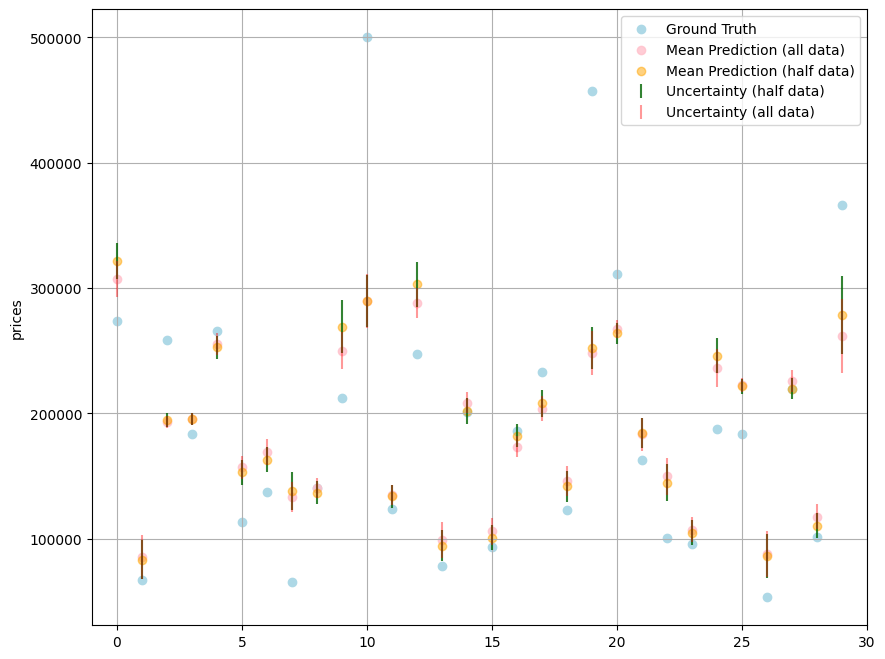

In [583]:
plt.figure(figsize=(10, 8))
plt.xlim(-1,PLOT)
plt.scatter(x_axis, y_plot, color='lightblue', label="Ground Truth")
plt.scatter(x_axis, y_mean_predict.flatten(), color='pink', alpha=0.8, label='Mean Prediction (all data)')
# plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=root_mse, fmt='none', ecolor='pink', label="Root MSE (all data)")

plt.scatter(x_axis, y_50_mean_predict.flatten(), color='orange', alpha=0.5, label='Mean Prediction (half data)')
# plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=root_mse_50, fmt='none', ecolor='yellow', alpha=0.6, label="Root MSE (half data)")


plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=y_50_sd_predict.flatten(), fmt='none', color='darkgreen', alpha=0.8, label="Uncertainty (half data)")
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=y_var_predict.flatten(), fmt='none', color='red', alpha=0.4, label="Uncertainty (all data)")

plt.ylabel('prices')
plt.legend()
plt.grid(True)  # Enable grid for better visualization
plt.show()

In [584]:
# find the data points with the largest and smallest difference

In [585]:
print(y_test.loc[[128]])

     Median_House_Value
128            500001.0


In [586]:
gbt_explanation_lime = gbt_model.explain_lime(X_test.loc[[128]])

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 25/157 [===>..........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 45/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 46/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 71/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 15s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 23/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 15s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 22/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 22/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 2ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 22/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 5s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 47/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [589]:
gbt_explanation_50_lime = gbt_model_50.explain_lime(X_test.loc[[128]])

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 25/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 15s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 6s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 4s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 22/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 2ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [587]:
gbt_explanation_shap=gbt_model.explain_shap(X_test.loc[[128]])

In [588]:
gbt_explanation_50_shap=gbt_model_50.explain_shap(X_test.loc[[128]])

In [590]:
for i, explanation in enumerate(gbt_explanation_lime):
    print(f"Explanation {i + 1}:")
    print("As List of Tuples (feature_id, weight):")
    for feature_id, weight in explanation.as_list():
        print(f"Feature {feature_id}: {weight}")

    print("\n")

Explanation 1:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 150247.14852033494
Feature Distance_to_coast > 0.19: -70394.63738353034
Feature Latitude > 0.97: -23837.010434053576
Feature Distance_to_LA > 1.04: -13580.290503599892
Feature Population > 0.27: -10852.795496198587
Feature Distance_to_SanJose > 0.77: -9504.964039540868
Feature Households > 0.28: 7946.192934369978
Feature Median_Age > 0.66: 7620.193666765936
Feature Tot_Bedrooms > 0.26: 6497.701788352966
Feature Distance_to_SanFrancisco > 0.79: -4006.0827894876443
Feature Tot_Rooms > 0.24: 3591.9711333666833
Feature Longitude <= -1.11: 1452.1368849162127
Feature Distance_to_SanDiego > 1.06: 721.4468280299956


Explanation 2:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 124533.77692921046
Feature Distance_to_coast > 0.19: -52479.372446639936
Feature Latitude > 0.97: -10590.844495156842
Feature Median_Age > 0.66: 7379.830637122425
Feature Distance_to_SanJose > 0.77: -6127.83285851

In [591]:
print(gbt_explanation_shap[0].values)

[[221770.00675239   9995.10090929   4803.27681207   7074.12076172
   -6637.91786024   3793.6567513   -9693.57722331   2325.9665842
  -60904.09253255  -8483.11350477   1949.58713542  -7303.95737739
   -1250.31349718]]


In [592]:
feature_weights = defaultdict(list)

for explanation in gbt_explanation_lime:
    for feature, weight in explanation.as_list():
        feature_weights[feature].append(weight)

feature_stats = {}
for feature, weights in feature_weights.items():
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)
    feature_stats[feature] = {'mean': mean_weight, 'std': std_weight}

print(feature_stats)

{'Median_Income > 0.46': {'mean': 141744.31941031356, 'std': 12623.09759972198}, 'Distance_to_coast > 0.19': {'mean': -65567.87592006146, 'std': 7008.947437657961}, 'Latitude > 0.97': {'mean': -20528.805666265576, 'std': 8059.701505975215}, 'Distance_to_LA > 1.04': {'mean': -9996.82801996383, 'std': 5104.91656063703}, 'Population > 0.27': {'mean': -4589.260883616835, 'std': 5741.741293155995}, 'Distance_to_SanJose > 0.77': {'mean': -6125.671377884524, 'std': 2880.173237595209}, 'Households > 0.28': {'mean': 1386.785785008879, 'std': 2403.72575265485}, 'Median_Age > 0.66': {'mean': 8047.215296658336, 'std': 1934.2056489728425}, 'Tot_Bedrooms > 0.26': {'mean': 6084.930728000354, 'std': 5303.882550364866}, 'Distance_to_SanFrancisco > 0.79': {'mean': -3646.7946010415594, 'std': 2678.01461372757}, 'Tot_Rooms > 0.24': {'mean': 3498.896282870366, 'std': 4493.889816077509}, 'Longitude <= -1.11': {'mean': 4027.4463782261323, 'std': 4121.349740072934}, 'Distance_to_SanDiego > 1.06': {'mean': 171

In [593]:
feature_order = X_test.columns.tolist()
def sort_key(x):
    for op in [' >= ', ' <= ', ' > ', ' < ', ' = ']:
        if op in x:
            return feature_order.index(x.split(op)[0])
        
sorted_keys = sorted(feature_stats.keys(), key=sort_key)
sorted_feature_stats = {key: feature_stats[key] for key in sorted_keys}

print(sorted_feature_stats)

{'Median_Income > 0.46': {'mean': 141744.31941031356, 'std': 12623.09759972198}, 'Median_Age > 0.66': {'mean': 8047.215296658336, 'std': 1934.2056489728425}, 'Tot_Rooms > 0.24': {'mean': 3498.896282870366, 'std': 4493.889816077509}, 'Tot_Bedrooms > 0.26': {'mean': 6084.930728000354, 'std': 5303.882550364866}, 'Population > 0.27': {'mean': -4589.260883616835, 'std': 5741.741293155995}, 'Households > 0.28': {'mean': 1386.785785008879, 'std': 2403.72575265485}, 'Latitude > 0.97': {'mean': -20528.805666265576, 'std': 8059.701505975215}, 'Longitude <= -1.11': {'mean': 4027.4463782261323, 'std': 4121.349740072934}, 'Distance_to_coast > 0.19': {'mean': -65567.87592006146, 'std': 7008.947437657961}, 'Distance_to_LA > 1.04': {'mean': -9996.82801996383, 'std': 5104.91656063703}, 'Distance_to_SanDiego > 1.06': {'mean': 1717.391522922778, 'std': 1887.8397691950786}, 'Distance_to_SanJose > 0.77': {'mean': -6125.671377884524, 'std': 2880.173237595209}, 'Distance_to_SanFrancisco > 0.79': {'mean': -36

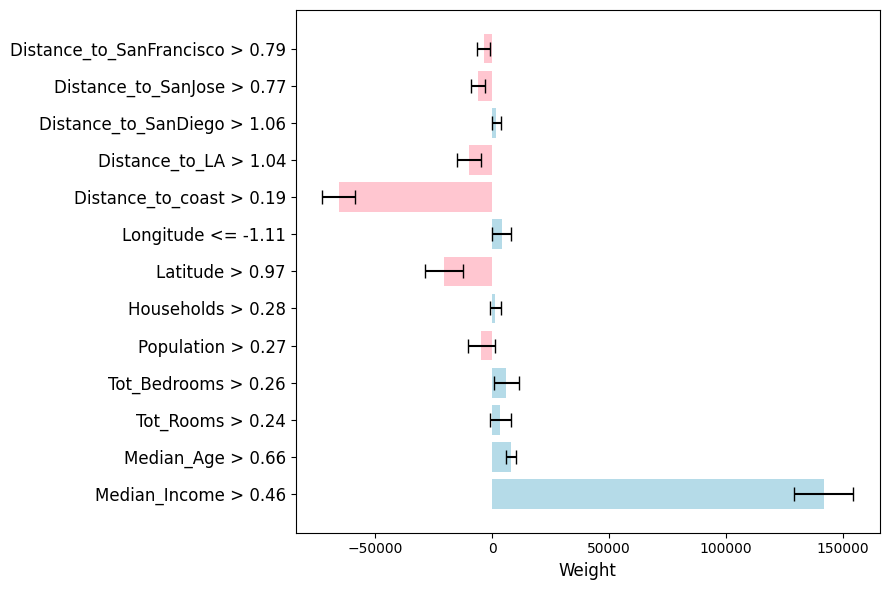

weights [141744.31941031356, 8047.215296658336, 3498.896282870366, 6084.930728000354, -4589.260883616835, 1386.785785008879, -20528.805666265576, 4027.4463782261323, -65567.87592006146, -9996.82801996383, 1717.391522922778, -6125.671377884524, -3646.7946010415594] sd [12623.09759972198, 1934.2056489728425, 4493.889816077509, 5303.882550364866, 5741.741293155995, 2403.72575265485, 8059.701505975215, 4121.349740072934, 7008.947437657961, 5104.91656063703, 1887.8397691950786, 2880.173237595209, 2678.01461372757]


In [594]:
features = list(sorted_feature_stats.keys())
mean_weights = [sorted_feature_stats[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

In [595]:
stacked_shap_values = np.vstack([gbt_explanation_shap[i].values for i in range(len(gbt_explanation_shap))])
mean_shap_values = np.mean(stacked_shap_values, axis=0)
sd_shap_values = np.std(stacked_shap_values, axis=0)
shap_features = X_test.loc[[10]].columns.tolist()

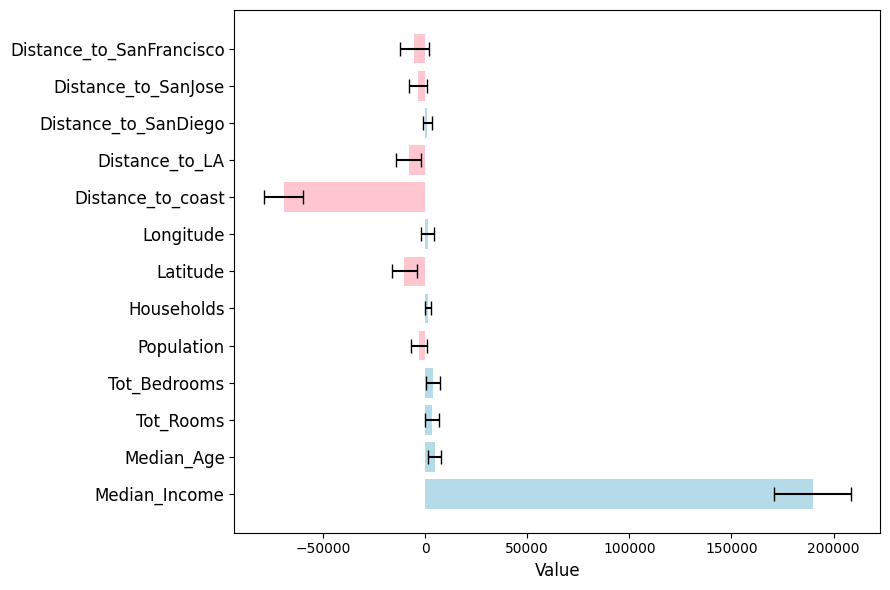

In [596]:

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_shap_values]

feature_ids = range(len(mean_shap_values))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values, xerr=sd_shap_values, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.tight_layout()
plt.show()

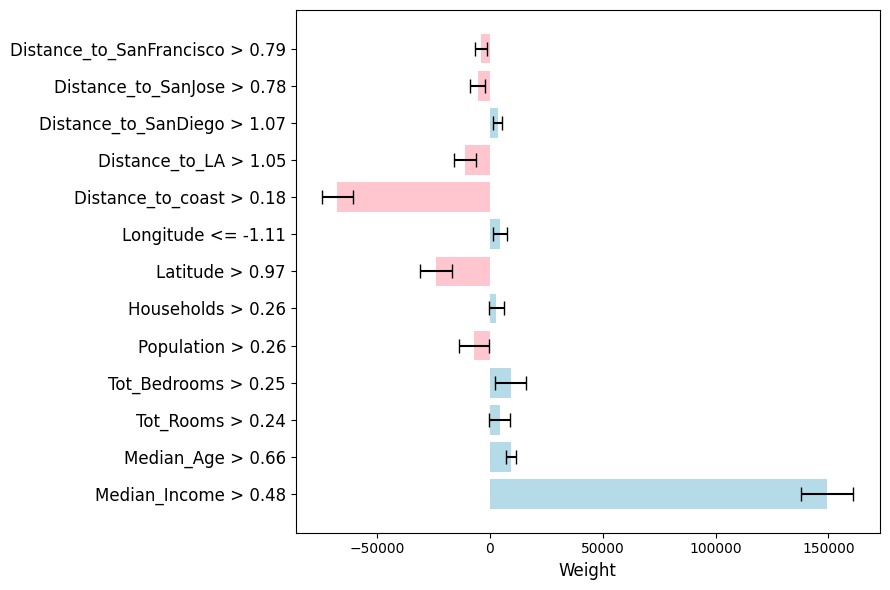

weights [149460.94764629783, 9342.313728028545, 4354.840717234069, 9258.253117116645, -6916.82594070198, 2885.029836150428, -23854.388831479977, 4424.758359524048, -67534.55357481947, -11091.904735380658, 3428.4701114118375, -5425.637683795341, -3758.4411561103893] sd [11641.758854872562, 2223.6973331845966, 4519.440729889195, 6777.814669775563, 6666.3633393947, 3243.757284217864, 7305.845955517341, 2974.5499872079467, 6704.285966078871, 4883.395989533453, 2124.996916751219, 3150.799008869906, 2718.6283728284]


In [597]:
feature_weights_50 = defaultdict(list)

for explanation in gbt_explanation_50_lime:
    for feature, weight in explanation.as_list():
        feature_weights_50[feature].append(weight)

feature_stats_50 = {}
for feature, weights in feature_weights_50.items():
    mean_weight_50 = np.mean(weights)
    std_weight_50 = np.std(weights)
    feature_stats_50[feature] = {'mean': mean_weight_50, 'std': std_weight_50}

sorted_keys_50 = sorted(feature_stats_50.keys(), key=sort_key)
sorted_feature_stats_50 = {key: feature_stats_50[key] for key in sorted_keys_50}

features = list(sorted_feature_stats_50.keys())
mean_weights = [sorted_feature_stats_50[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats_50[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

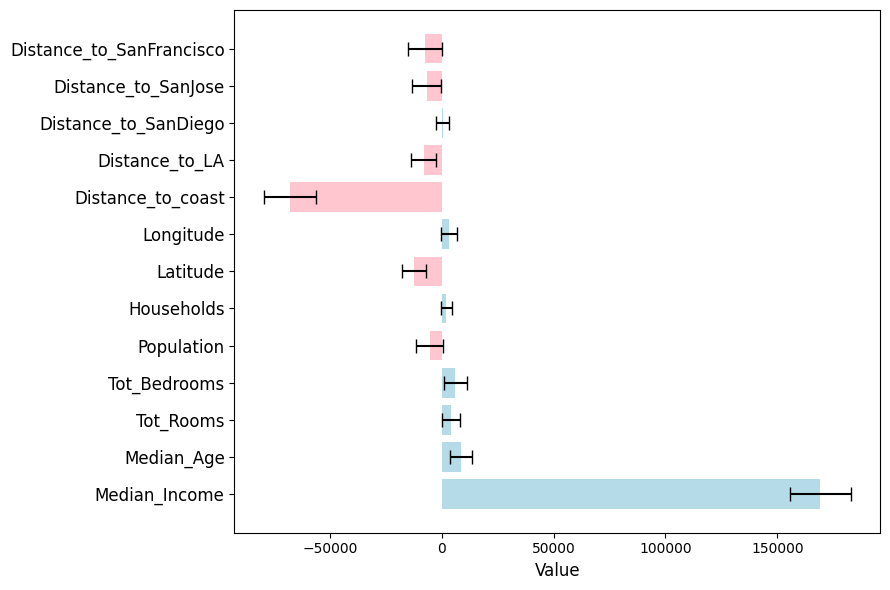

In [598]:

stacked_shap_values_50 = np.vstack([gbt_explanation_50_shap[i].values for i in range(len(gbt_explanation_50_shap))])
mean_shap_values_50 = np.mean(stacked_shap_values_50, axis=0)
sd_shap_values_50 = np.std(stacked_shap_values_50, axis=0)
shap_features = X_test.loc[[10]].columns.tolist()

feature_ids = range(len(mean_shap_values_50))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values_50, xerr=sd_shap_values_50, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.tight_layout()
plt.show()